# AutoML for Model Compression

This notebook will help visualize and review the results of recreating the results of [AMC](https://arxiv.org/abs/1802.03494).


AMC trains a [Deep Deterministic Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/ddpg.html) (DDPG) RL agent to compress DNNs.  For the implementation of DDPG I'm using [Coach](https://github.com/NervanaSystems/coach), which is developed and maintained by a team of my colleagues at Intel AI Lab.  Coach is arguably the richest open-source RL framework currently available for RL research, with loads of implemented algorithms and supported RL environments.  We wrap Distiller in an OpenAI Gym environment API (https://github.com/openai/gym) so that it presents a new environment to Coach.  We execute Distiller's sample application ```compress_classifier.py``` with special arguments telling it how to invoke AMC.  This creates a ```DistillerWrapperEnvironment``` environment and a DDPG agent and starts the training cycle.  For the exact technical details of doing this yourself, see the documentation at the top of ```examples/automated_deep_compression/ADC.py``` (note that in some cases the code uses ADC - [Automated Deep Compression](https://www.researchgate.net/publication/323141651_ADC_Automated_Deep_Compression_and_Acceleration_with_Reinforcement_Learning) - the name of the first version of the AMC paper).

This notebook only reviews Resource-Constrained Compression.  Specifically, I want to recreate the results of the first row of Table 2: using AMC $R_{err}$ on Plain20-CIFAR with a 50% FLOPs constraint.  I pasted Table 2 below with the experiment we are recreating highlighted. 
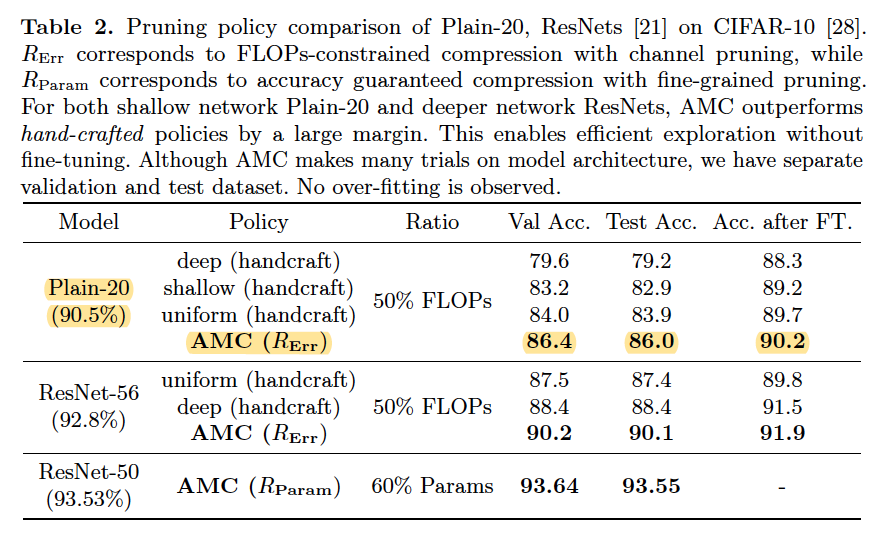

Plain20 is defined in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) and it is essentially ResNet20-CIFAR without the residual connections.  You will need to train this network first and you can do that using ```examples/automated_deep_compression/plain20_cifar_baseline_training.yaml```.  The trained Plain20 achieves Top1 accuracy of 90.5% on CIFAR-10.
The notebook uses data captured in Distiller AMC trace files.

## TLDR

It doesn't work for me yet.  The agent seems to learn one action: minimize sparsity (i.e. prune as little as possible).  

Your help is welcome!

## Experiment setup

Let's let AMC run the full-course: about 635 episodes.  We *heat up* for the first 100 episodes.  During this phase we don't train: the **Actor** emits actions, to which we add a strong constant noise and fill the Replay Buffer (the AMC paper refers to this phase as the *Exploration Phase*).
After completing the **heatup phase** (100 episodes) we start the learning phase (in AMC parlance this is the *Exploitation Phase*) in which we use an exponentially-decaying noise.  

How should the learning process look like (e.g. the reward curve)?  Unfortunately, the AMC paper provides very little information about this.  In the ADC paper we find Diagram 2 which provides some clues (why was this removed from AMC?).  Remember that RL learning is stochastic and two executions of the same experiment can look quite different: one succeeding and another failing - so we need to run our experiments several time.  I assume that ADC-Diagram 2 is a best-case scenario.

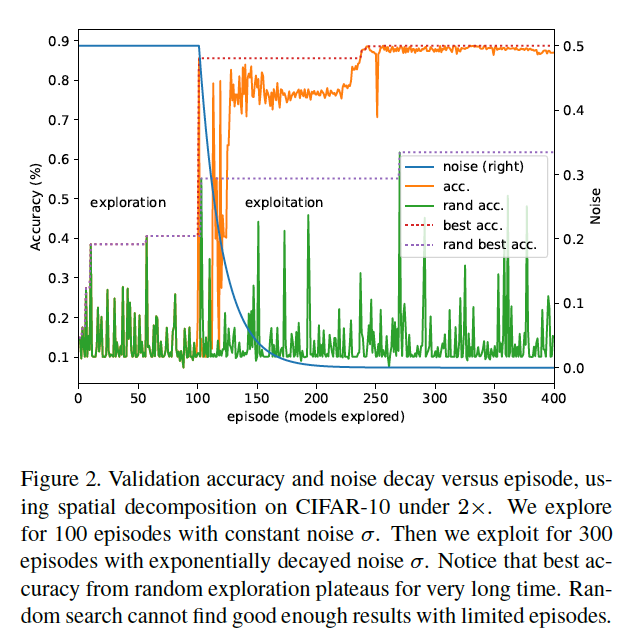

### DDPG configuration
Actor network: 
 - Two hidden layers, each with 300 units. 
 - Final output layer: sigmoid layer to bound the actions within (0; 1). 
Critic network (Q):
 - Two hidden layers, each with 300 units. 
 - Actions were included in the second hidden layer. 
 - 0.01 for the soft target updates. 
Training:
 - Batch size = 64
 - Replay buffer size = 2000. 
 - Exploration noise: truncated normal distribution. Constant 0.5 during exploration; exponential decay during exploitation

### Distiller AMC experiments
Let's look at three executions of 50% FLOPs-Constrained Compression of Plain20:
```
$ python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --resume=plain20.checkpoint.pth.tar --lr=0.05 --amc --amc-action-range 0.05 0.80 --vs=0.8
```

## Notebook code

Skip this part - it is necessary only for creating the diagrams.  You may also toggle the code-view button.

In [1]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off code view"></form>''')

NameError: name 'HTML' is not defined

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib 
import csv
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML


#plt.style.use('seaborn') # pretty matplotlib plots

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    if y < 1:
        y = str(100 * y)
    s = str(y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
# Widen the cells to get entire rows in the screen.
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


def plot_layer_densities(df, idx, action_type='action_history', ax=None, color=None):
    if ax is None:
        plt.figure()
        ax = plt
    
    record = df.iloc[idx]
    layer_sparsities = record[action_type]
    layer_sparsities = layer_sparsities[1:-1].split(",")
    layer_densities = [1.- float(sparsity) for sparsity in layer_sparsities]
    ax.bar(range(len(layer_densities)), layer_densities, color=color)
    ax.set_title("Ep:{} - Top1:{:.1f}%\nMACs:{:.1f}%".format(record['episode'], 
                                                             record['top1'], 
                                                             record['normalized_macs']))
    
    
def smooth(data, win_size):
    win_size = max(1, win_size)
    return [np.mean(data[max(0, i-win_size):i]) for i in range(len(data))]


def plot_performance(alpha, window_size, top1, macs, params, reward):
    plot_kwargs = {"figsize":(15,7), "lw": 1, "alpha": alpha, "title": "Performance Data"}
    smooth_kwargs = {"lw": 2, "legend": True}
    if top1:
        ax = df['top1'].plot(**plot_kwargs, color="b", grid=True)
        ax.set(xlabel="Episode", ylabel="(%)")
        df['smooth_top1'] = smooth(df['top1'], window_size)
        df['smooth_top1'].plot(**smooth_kwargs, color="b")
    if macs:
        ax = df['normalized_macs'].plot(**plot_kwargs, color="r")
        ax.set(xlabel="Episode", ylabel="(%)")
        df['smooth_normalized_macs'] = smooth(df['normalized_macs'], window_size)
        df['smooth_normalized_macs'].plot(**smooth_kwargs, color="r")
    if params:
        ax = df['normalized_nnz'].plot(**plot_kwargs, color="black")
        ax.set(xlabel="Episode", ylabel="(%)")
        df['smooth_normalized_nnz'] = smooth(df['normalized_nnz'], window_size)
        df['smooth_normalized_nnz'].plot(**smooth_kwargs, color="black")        
    if reward:
        ax = df['reward'].plot(**plot_kwargs, secondary_y=True, color="g")
        ax.set(xlabel="Episode", ylabel="reward")
        df['smooth_reward'] = smooth(df['reward'], window_size)
        df['smooth_reward'].plot(**smooth_kwargs, secondary_y=True, color="g")    
    ax.grid(True, which='minor', axis='x', alpha=0.3)
        
        
def plot_2d_embeddings(top1, normalized_macs):
    plt.figure(figsize=(15,7))        
    plt.title('Projection of Discovered Networks ({})'.format(len(top1)))     
    plt.xlabel('Normalized MACs')
    plt.ylabel('Top1 Accuracy')

    # Create the formatter using the function to_percent. This multiplies all the
    # default labels by 100, making them all percentages
    formatter = FuncFormatter(to_percent)

    # Set the formatter
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)

    # Use color gradients to show the "age" of the network:
    # Lighter networks were discovered earlier than darker ones.
    color_grad = [str(1-i/len(top1)) for i in range(len(top1))]
    plt.scatter(normalized_macs, top1, color=color_grad, s=80, edgecolors='gray');

    
INTERVAL = 100 # Animation speed
WINDOW = 20

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'alpha': 0.50,
        'size': 32,
        }

# Based on these two helpful example code: 
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/.
# Specifically, the use of IPython.display is missing from the first example, but most of the animation code
# leverages code from there.
class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, xdata, ydata):
        assert len(xdata) == len(ydata)
        self.numpoints = len(xdata)
        self.xdata = xdata
        self.ydata = ydata
        self.stream = self.data_stream()

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots(figsize=(15,7))
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=INTERVAL,
                                           frames=self.numpoints-2, 
                                           init_func=self.setup_plot, blit=True)

    def setup_plot(self):
        """Initialize drawing of the scatter plot."""
        x, y, s, c = next(self.stream)
        #self.annot = self.ax.annotate("txt", (10, 10))
        self.scat = self.ax.scatter(x, y, c=c, s=s, animated=False)
        self.scat.set_edgecolors('gray')
        self.scat.set_cmap('gray')
        self.width = max(self.xdata) - min(self.xdata) + 4
        self.height = max(self.ydata) - min(self.ydata) + 4
        self.ax.axis([min(self.xdata)-2, max(self.xdata)+2, 
                      min(self.ydata)-2, max(self.ydata)+2])
        
        self.annot = self.ax.text(min(self.xdata) + self.width/2, 
                     min(self.xdata) + self.height/2, 
                     "", fontdict=font)
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat, 

    def data_stream(self):
        numpoints = 0#len(self.xdata)
        colors = []
        xxx = 0
        while True:
            numpoints += 1
            win_len = min(WINDOW, numpoints)
            data = np.ndarray((4, win_len))
            start = max(0,numpoints-WINDOW-1)
            data[0, :] = self.xdata[start:start+win_len]
            data[1, :] = self.ydata[start:start+win_len]
            data[2, :] = [70] * win_len  # point size
            #data[3, :] = [np.random.random() for p in range(numpoints)]  # color
            # The color of the points is a gradient with larger values for "younger" points.
            # At each new frame we show one more point, and "age" each existing point by incrementaly  
            # reducing its color gradient.
            data[3, :] = [(1-i/(win_len+1)) for i in range(win_len)] 
            yield data

    def update(self, i):      
        """Update the scatter plot."""
        data = next(self.stream)
        self.annot.set_text(i)
        i = i % len(data)
            
        # Set x and y data
        xy = [(data[0,i], data[1,i]) for i in range(len(data[0,:]))]
        self.scat.set_offsets(xy)
        
        # Set colors
        self.scat.set_array(data[3])
        
        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat, self.annot

    def show(self):
        plt.show()

## Results

Below I present the results of a single execution.  There is a substantial variance between the experiment executions, but most conclude similarly to this experiment.

### Read the results log files

The code below reads the log file of your selected experiment.  To change the path to the file you will need to open the code cell and change its content.

In [3]:
pd.set_option('display.max_colwidth', 150)

fname = "sample_logs/coach_rl/AMC-Plain20___2018.12.29-033839/amc.csv"
#fname = "../classifier_compression/latest_log_dir/amc.csv"
#fname = "../classifier_compression/experiments/AMC-7-Plain20-accuracy-guaranteed___2019.01.02-090343/amc.csv"
#fname = "../classifier_compression/experiments/AMC-7-Plain20-accuracy-guaranteed___2019.01.02-115638/amc.csv"
#fname = "../classifier_compression/experiments/AMC-7-Plain20-accuracy-guaranteed___2019.01.02-123446/amc.csv"
#fname = "../classifier_compression/experiments/AMC-7-Plain20-mac-constrained___2019.01.02-130810/amc.csv"
#fname = "../classifier_compression/experiments/AMC-7-Plain20-mac-constrained___2019.01.02-150654/amc.csv"
#fname = "../classifier_compression/experiments/AMC-7-Plain20-mac-constrained___2019.01.02-232019/amc.csv"
#fname = "../classifier_compression/experiments/AMC-3-VGG16-mac-constrained___2019.01.02-232141/amc.csv"
#fname = "../classifier_compression/experiments/AMC-3-VGG16-mac-constrained___2019.01.03-023137/amc.csv"

df = pd.read_csv(fname)
#print(df.loc[df['reward'].idxmax()])

### Plot experiment performance

In [4]:
plt.figure(figsize=(15,7))
#print(plt.style.available)
#plt.style.use('bmh')

@interact(window_size=(0,50,5), top1=True, macs=True, params=False, reward=True)
def plot_performance_proxy(window_size=10, top1=True, macs=True, params=False, reward=True):
    plot_performance(0.15, window_size, top1, macs, params, reward)
    
#plot_performance(0.15, window_size=10, top1=True, macs=True, params=False, reward=True)

<Figure size 1080x504 with 0 Axes>

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), Checkbox(value=True, description='top1'), Checkbox(value=True, description='macs'), Checkbox(value=False, description='params'), Checkbox(value=True, description='reward'), Output()), _dom_classes=('widget-interact',))

What do we see?
 - The networks stay within the alloted 50% MACs compute budget.
 - During the exploration phase (heatup) there's quite a lot of noise and we see some promising Top1 accuracy results, and as the noise is reduced and the network begins learning we see more signs of hope, but alas, the Reward and Top1 drop and never recover.
 - What happened?  The agent learns very quickly to maximize the compute budget (50% MACs) and stops producing smaller networks.  But why can't it reach the high Reward values it encountered during the exploration?? There are some clues below.

### Sample some networks

Let's look at the networks with the best top1 accuracy, and see if they share geometrical attributes.

We sort the discovered networks by their Top1 accuracy and display the density of each layer in the networks.  We can see that the layer densities are distributed differently in each of the networks.  

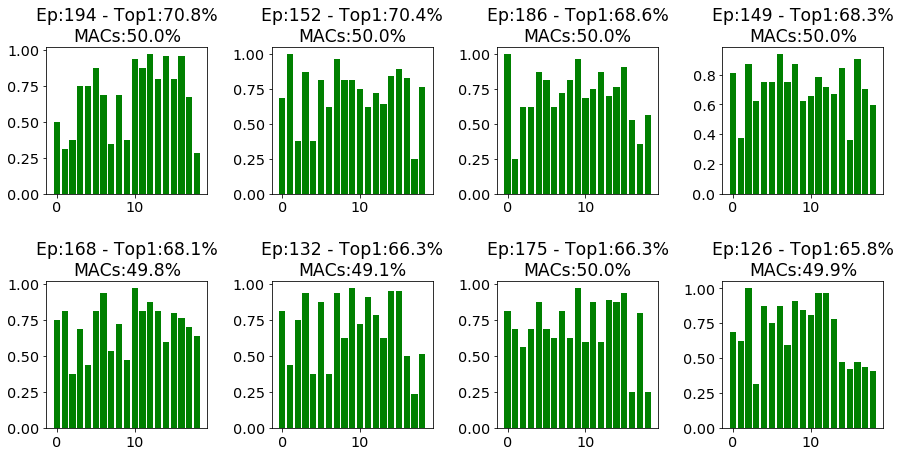

In [5]:
top1_sorted_df = df.sort_values(by=['top1'], ascending=False)
nrows = 2; ncols = 4
f, axarr = plt.subplots(nrows, ncols, figsize=(15,7))
for i in range(0, nrows * ncols):
    plot_layer_densities(top1_sorted_df, i, ax=axarr[i//ncols, i%ncols], color='g')
    # Fine-tune figure; make subplots farther from each other.
    f.subplots_adjust(hspace=0.6, wspace=0.4)

#pd.set_option('display.max_colwidth', -1)

Now let's sample networks from episodes 251 through 274 - and notice what happens from about episode 126: the first layers are very dense (~0%-10% sparse) and the following layers have higher sparsities.

What's going on?  Ironically, the agent learns to minimize pruning actions (minimize sparsity) so it generates dense/wide layers until the environment has to step-in and increase the actions so that the final network's compute complexity remains within the 50% MACs budget.  Clearly, these networks (dense/wide early layers followed by sparse/shallow layers) have low Top1 accuracies, but it's too late: the Agent has learned one action - very low sparsity.  And so this goes on forever.

Why did the Agent learn this?  It's as if there is only one state to which the Agent learned one action.
Either the agent is confused by the observations and all states look the same, or all actions are generated by the same process.

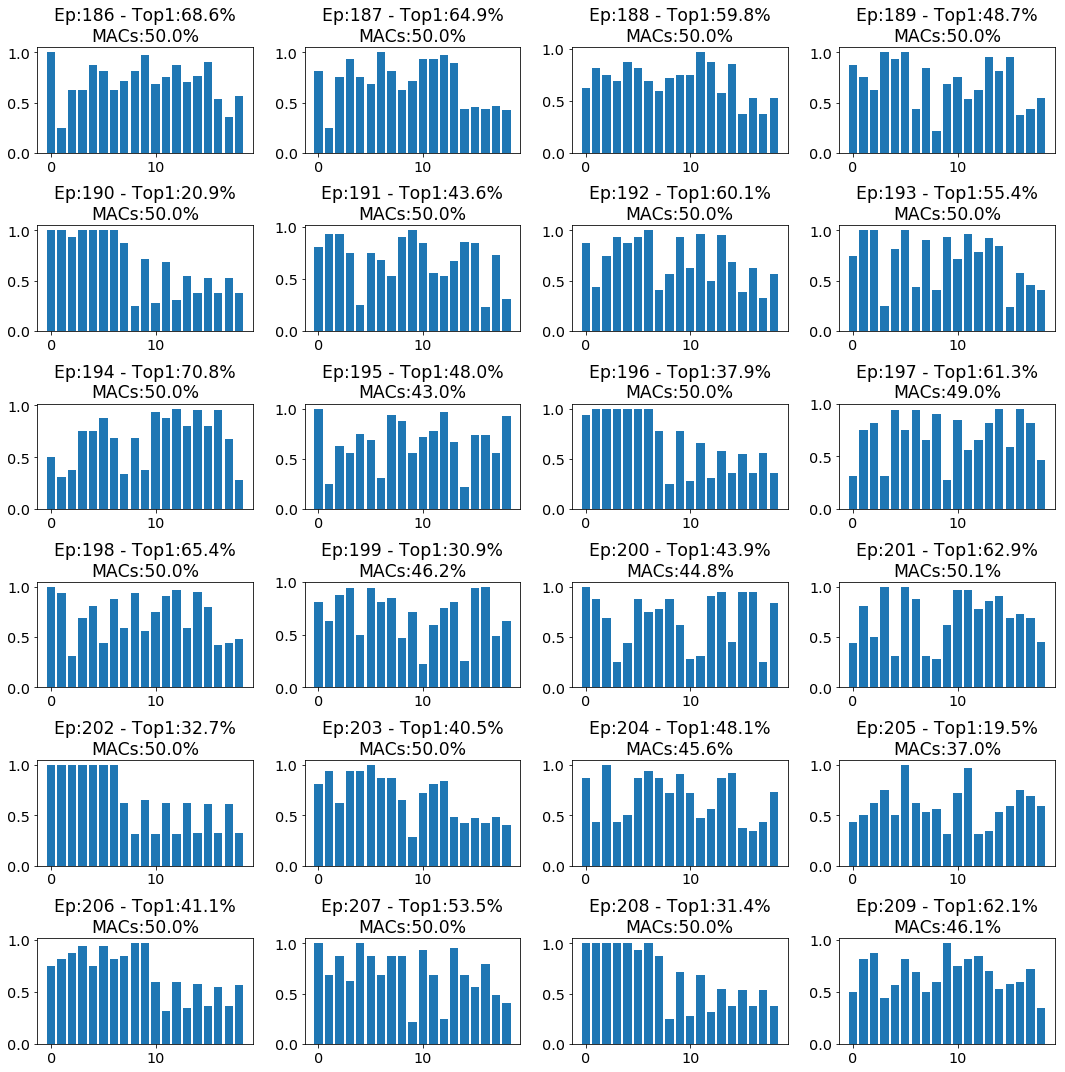

In [6]:
# Display networks in chronological order (of time of discovery)
nrows = 6; ncols = 4
first_network = 185 # 115
f, axarr = plt.subplots(nrows, ncols, figsize=(15,15))
for i in range(0, nrows * ncols):
    plot_layer_densities(df, first_network + i, ax=axarr[i//ncols, i%ncols])
    # Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.6, wspace=0.4)
f.tight_layout()

And here's the **smoking gun**: these are the actions that the DDPG agent generated, before they were constrained by the AMC algorithm (i.e. function ```DistillerWrapperEnvironment.get_action```).  Here we can clearly see that the Agent learned to emit low-sparsity actions.

Using the interactive GUI you can play back the action trajectories that the Actor emitted.

In [9]:
@interact(episode=(0,len(df.index)-1,1))
def display_ddpg_actions(episode=0):
    f = plt.figure(figsize=(15,7))
    ax1 = f.add_subplot(111)
    ax2 = ax1.twiny()
    ax2.set_xlim((1,len(df.index)))
    record = df.iloc[episode]
    layer_sparsities = record["agent_action_history"]
    layer_sparsities = layer_sparsities[1:-1].split(",")
    layer_densities = [1.- float(sparsity) for sparsity in layer_sparsities]
    ax1.bar(range(len(layer_densities)), layer_densities, color="gray")
    ax2.plot(df['top1']/100)
    plt.title("DDPG Pruning Action History\nEpisode:{} - Top1:{:.1f}% - MACs:{:.1f}%\n\n\n".format(
              record['episode'], record['top1'], record['normalized_macs']))
    ax1.set_xlabel("Layer")
    ax2.set_xlabel("Episode")
    plt.ylim([0,1])
    plt.ylabel("Depth/Density (%)")


interactive(children=(IntSlider(value=0, description='episode', max=459), Output()), _dom_classes=('widget-interact',))

### Network 2D embeddings

Let's create an embedding of the networks AMC discovers over the course of each experiment session.  Each network is projected onto a 2D plane mapping the Top1 accuracy versus the compute budget, and is represented by a small circle. I used gradient-color-coding to show the relative phase where each network is discovered.  Lighter circles are networks discovered early in the search, darker networks are discovered later.

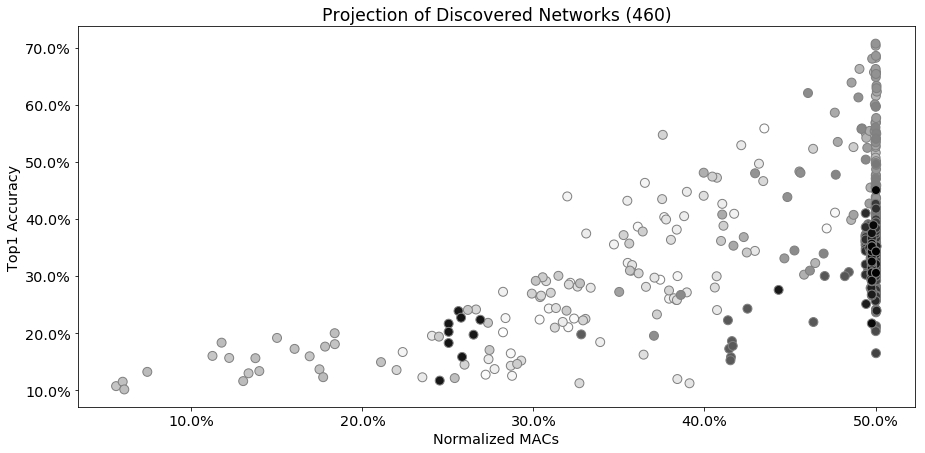

In [10]:
top1 = df['top1']
normalized_macs = df['normalized_macs']
plot_2d_embeddings(top1, normalized_macs)

### Accuracy contour

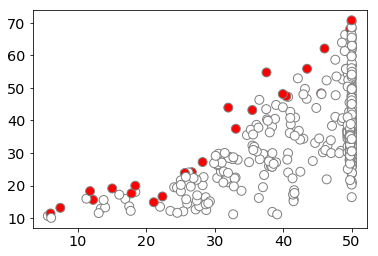

In [11]:
BIN_SIZE = 2# 0.5
NUM_BINS = int(100 / BIN_SIZE)
compute_bins = [None] * NUM_BINS
color_grad_ = ["1" for _ in top1]

idx_bins = [-1] * NUM_BINS

draw_what = "accuracy contour"
draw_what = "mac contour"
if draw_what == "accuracy contour":
    for i,accuracy in enumerate(top1):
        bin_id = int(accuracy // BIN_SIZE)
        try:
            if compute_bins[bin_id] is None or compute_bins[bin_id] > normalized_macs[i]:
                compute_bins[bin_id] = normalized_macs[i]
                idx_bins[bin_id] = i
        except TypeError:
            pass
else:
    for i,compute in enumerate(normalized_macs):
        bin_id = int(compute // BIN_SIZE)
        try:
            #print(bin_id)
            if compute_bins[bin_id] is None or compute_bins[bin_id] < top1[i]:
                compute_bins[bin_id] = top1[i]
                idx_bins[bin_id] = i
        except TypeError:
            pass
    
for i in idx_bins:
    if i != -1:
        color_grad_[i] = "red"
plt.scatter(normalized_macs, top1, color=color_grad_, s=80, edgecolors='gray');

### Video animation

In [ ]:
a = AnimatedScatter(normalized_macs, top1)
plt.title('Projection of Discovered Networks ({})'.format(len(top1)))  
plt.xlabel('Normalized MACs')
plt.ylabel('Top1 Accuracy')
#a.ani.save('amc_vgg16.mp4', fps=10, dpi=80) #Frame per second controls speed, dpi controls the quality 
rc('animation', html='html5')
a.ani

### Performance Evaluation
OK, one thing stands-out: the best Top1 we see during our traversal of the compressed network sub-space is below 80%, while the AMC paper reports a Test accuracy of 86%.  The appendix to this notebook explains why this is so, but for now let's see if this is a problem: after all, what we really care about is reproducing the 90.2% Top1 score AMC reports on the fine-tuned network.

So let's get to it: Here are the results of fine-tuning for 30, 50, and 60 epochs.  At 60 epochs of fine-tuning, the Top1 is 88.42-90.18 = -1.76% off of the original Top1.  Here too, I am not able to get the paper's results (too many epochs; Top1 is not up to par).

```
time python3  compress_classifier.py --arch=plain20_cifar ../../../data.cifar10 --resume=logs/AMC-Plain20-algo1_more_training___2018.12.29-033839/BEST_adc_episode_194_checkpoint.pth.tar --lr=0.005 --epochs=30
```
==> Top1: 87.790    Top5: 99.370    Loss: 0.400
```
time python3  compress_classifier.py --arch=plain20_cifar ../../../data.cifar10 --resume=logs/AMC-Plain20-algo1_more_training___2018.12.29-033839/BEST_adc_episode_194_checkpoint.pth.tar --lr=0.005 --epochs=50
```
==> Top1: 88.310    Top5: 99.440    Loss: 0.402
```
time python3  compress_classifier.py --arch=plain20_cifar ../../../data.cifar10 --resume=logs/AMC-Plain20-algo1_more_training___2018.12.29-033839/BEST_adc_episode_194_checkpoint.pth.tar --lr=0.005 --epochs=60
```
==> **Top1: 88.420**    Top5: 99.390    Loss: 0.416



## Appendix: on the relative pruning robustness of Plain20 and VGG16 (CIFAR)

The diagrams below show the relative pruning sensitivity of Plain20 and VGG16 at 20% filter sparsity.

It is evident that VGG16 is much more robust compared to Plain20.

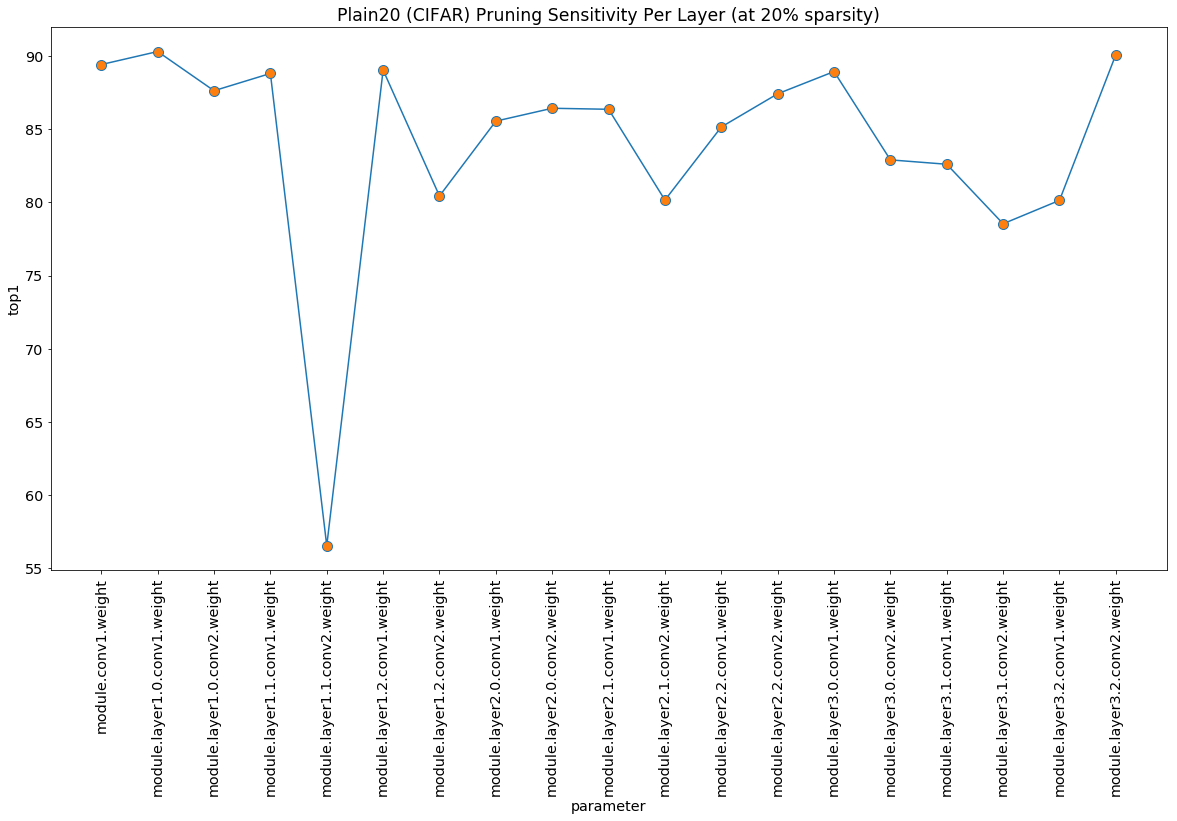

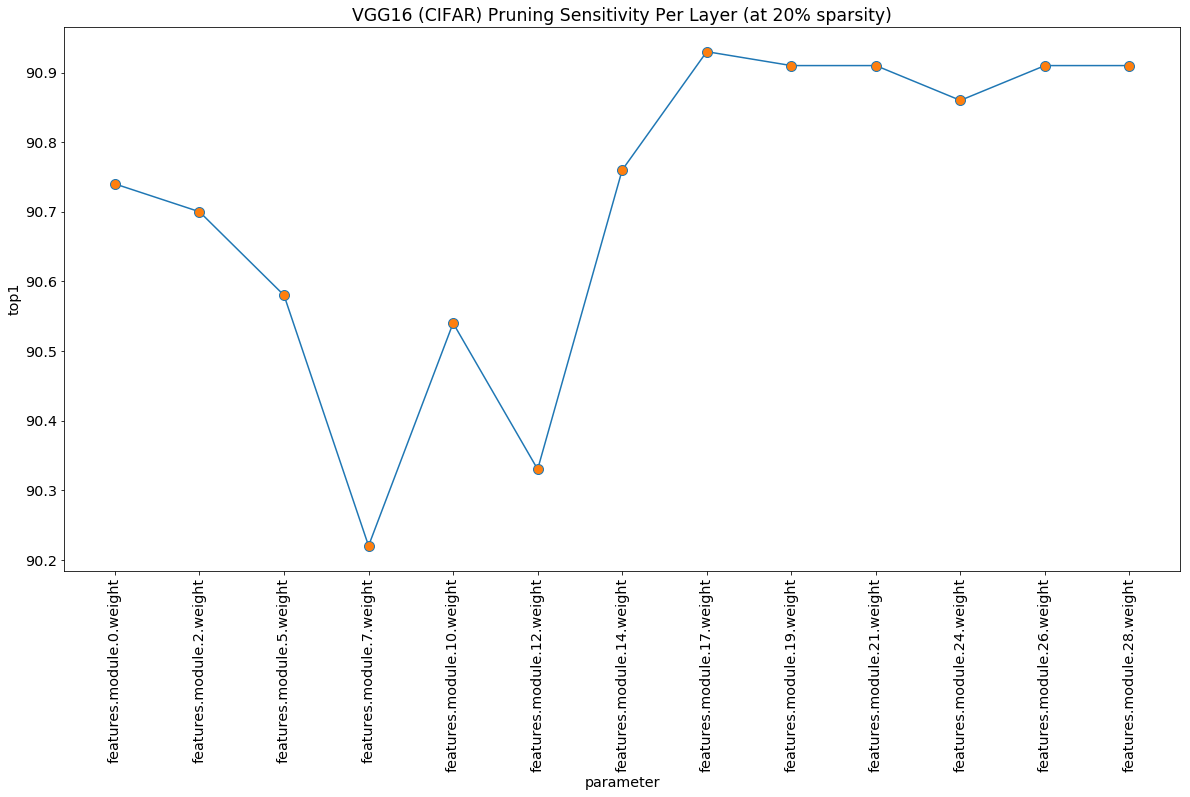

In [14]:
df_plain20_sensitivity = pd.read_csv('../sensitivity-analysis/plain20-cifar/plain20_cifar_sensitivity_filters.csv')
df_vgg16_sensitivity = pd.read_csv('../sensitivity-analysis/vgg16-cifar/vgg16_cifar_sensitivity_filters.csv')
df_plain20_sensitivity['sparsity'] = round(df_plain20_sensitivity['sparsity'], 2)
df_vgg16_sensitivity['sparsity'] = round(df_vgg16_sensitivity['sparsity'], 2)

def plot_sensitivity(df, level, acc, name):
    filtered = df[df.sparsity == level]
    #s = filtered.style.apply(highlight_min_max)
    
    param_names = filtered['parameter']
    
    # Plot the sensitivities
    x = range(filtered[acc].shape[0])
    y = filtered[acc].values.tolist()
    fig = plt.figure(figsize=(20,10))
    plt.plot(x, y, label=param_names, marker="o", markersize=10, markerfacecolor="C1")
    plt.ylabel(str(acc))
    plt.xlabel('parameter')
    plt.xticks(rotation='vertical')
    plt.xticks(x, param_names)
    plt.title('{} Pruning Sensitivity Per Layer (at {:.0f}% sparsity)'.format(name, level*100))

plot_sensitivity(df_plain20_sensitivity, 0.2, 'top1', name="Plain20 (CIFAR)")   
plot_sensitivity(df_vgg16_sensitivity, 0.2, 'top1', name="VGG16 (CIFAR)") 